In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/../src/simulations_v2")
    sys.path.append(module_path + "/..")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [2]:
from util_functions import *
from uncertainty_analysis import *
from sim_helper_functions import *
from plot_utils import *
configure_plot(plt)

In [3]:
lhs_output_sim_files = []
for i in range(2000):
    fname = '/home/aaj54/group-testing/notebooks/apr_29_scenarios/point_{}.dill'.format(i)
    lhs_output_sim_files.append(fname)

In [4]:
scenario_data = load_sim_output(lhs_output_sim_files)
res_results = residential_regression(scenario_data)
res_pessimistic = calculate_pessimistic_scenario(res_results)

In [5]:
res_pessimistic

{'ct_mult': 1.2818839899920873,
 'outside_inf_mult': 1.0286501693971972,
 'daily_self_report_prob': 0.34385098578293893,
 'inital_prev_mult': 1.0609799633016896,
 'Sy_time': 11.996988032512574,
 'ct_testing_ratio': 0.8111483773441324,
 'E_time': 1.9740136081212982,
 'ID_time': 3.118881361589655,
 'test_sensitivity': 0.5062818657108665,
 'test_noncompliance': 0.10613540939389178,
 'asymp_prob_mult': 1.1806596438994459,
 'R0': 3.717310827561512,
 'virtual_noncompliance': 0.5,
 'intermittent_non-compliance': 0.5,
 'virtual_r0_mult': 1.2349999999999999,
 'virtual_pop_size': 0.5}

In [6]:
results_summary = res_results.summary()
results_as_html = results_summary.tables[1].as_html()
lr_summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

coef_normalized = list()
for param, value in dict(lr_summary_df['coef']).items():
    if param == 'const':
        coef_normalized.append(value)
        continue
    param_range = PARAM_BOUNDS[param][1] - PARAM_BOUNDS[param][0]
    coef_normalized.append(value * param_range)
lr_summary_df['coef*range'] = coef_normalized

std_err_normalized = list()
for param, value in dict(lr_summary_df['std err']).items():
    if param == 'const':
        std_err_normalized.append(value)
        continue
    param_range = PARAM_BOUNDS[param][1] - PARAM_BOUNDS[param][0]
    std_err_normalized.append(value * param_range)
lr_summary_df['coef*range'] = coef_normalized
lr_summary_df['std err*range'] = std_err_normalized

In [7]:
# lr_summary_df.columns
lr_summary_df[['coef', 'std err', 'P>|t|', 'coef*range', 'std err*range']].round(3)

,coef,std err,P>|t|,coef*range,std err*range
const,1014.736,429.208,0.018,1014.736,429.208
asymp_prob_mult,570.451,60.968,0.000,558.314,59.671
inital_prev_mult,184.444,59.783,0.002,184.444,59.783
R0,409.106,19.885,0.000,1227.319,59.655
outside_inf_mult,86.657,59.519,0.146,86.657,59.519
daily_self_report_prob,-623.027,212.976,0.003,-174.448,59.633
ct_mult,-659.728,59.618,0.000,-659.728,59.618
ct_testing_ratio,-571.213,59.603,0.000,-571.213,59.603
test_sensitivity,-1771.662,149.238,0.000,-708.665,59.695
test_noncompliance,1855.755,596.420,0.002,185.576,59.642


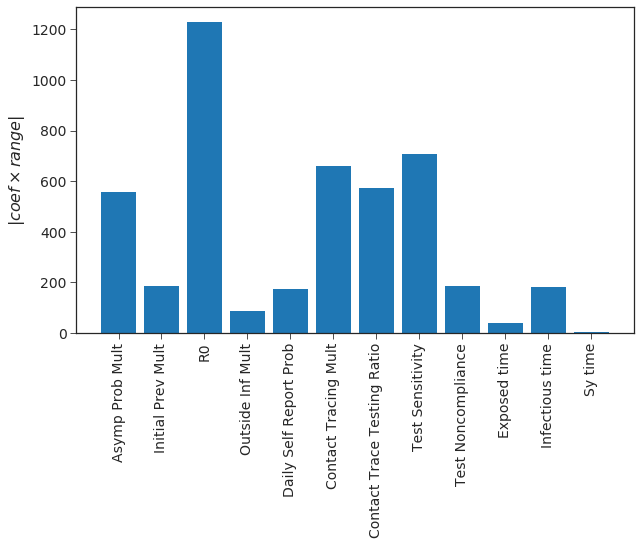

In [8]:
plt.figure(figsize=(10,6))
plt.bar(lr_summary_df.index[1:], np.abs(lr_summary_df['coef*range'])[1:])
# plt.ylabel('|coef * range|')
plt.ylabel(r"$\| coef \times range \|$")
# plt.xlabel('Feature')
# plt.xticks(rotation = 90)
plt.xticks(list(range(len(UNCERTAINTY_PARAMS_LIST[:12]))), ['Asymp Prob Mult', 'Initial Prev Mult', 'R0', 'Outside Inf Mult',
                                          'Daily Self Report Prob', 'Contact Tracing Mult', 'Contact Trace Testing Ratio',
                                          'Test Sensitivity', 'Test Noncompliance', 'Exposed time', 'Infectious time',
                                          'Sy time'], rotation=90)

plt.show()

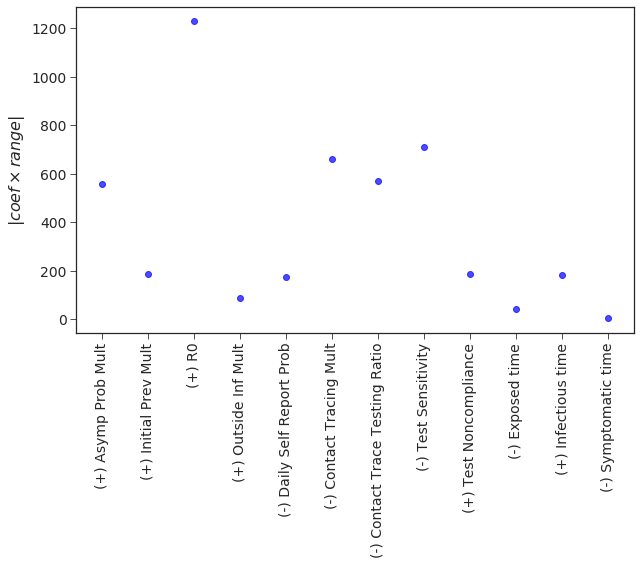

In [10]:
plt.figure(figsize=(10,6))

plt.scatter(x=lr_summary_df.index[1:], y=np.abs(lr_summary_df['coef*range'])[1:], label='Center', c='blue', alpha=0.7)
# plt.errorbar(x=lr_summary_df.index[1:], y=np.abs(lr_summary_df['coef*range'])[1:], yerr = 1.96/2 * np.array(lr_summary_df['std err*range'])[1:], fmt='o', label='Center', c='blue', alpha=0.7)

# plt.bar(lr_summary_df.index[1:], )
# plt.ylabel('|coef * range|')
plt.ylabel(r"$\| coef \times range \|$")
# plt.xlabel('Feature')
# plt.xticks(rotation = 90)
plt.xticks(list(range(len(UNCERTAINTY_PARAMS_LIST[:12]))), ['(+) Asymp Prob Mult', '(+) Initial Prev Mult', '(+) R0', '(+) Outside Inf Mult',
                                          '(-) Daily Self Report Prob', '(-) Contact Tracing Mult', '(-) Contact Trace Testing Ratio',
                                          '(-) Test Sensitivity', '(+) Test Noncompliance', '(-) Exposed time', '(+) Infectious time', '(-) Symptomatic time'], rotation=90)

plt.show()

In [19]:
1.96/2 * np.array(lr_summary_df['std err*range'])[1:]

array([58.47739234, 58.58734   , 58.4619    , 58.32862   , 58.4406144 ,
       58.42564   , 58.41094   , 58.501296  , 58.44916   , 58.43936   ,
       58.36488   , 58.35312   ])

In [12]:
def normalize_param(param_name, value):
    lower_bound = PARAM_BOUNDS[param_name][0]
    upper_bound = PARAM_BOUNDS[param_name][1]
    return (value - lower_bound) / (upper_bound - lower_bound)

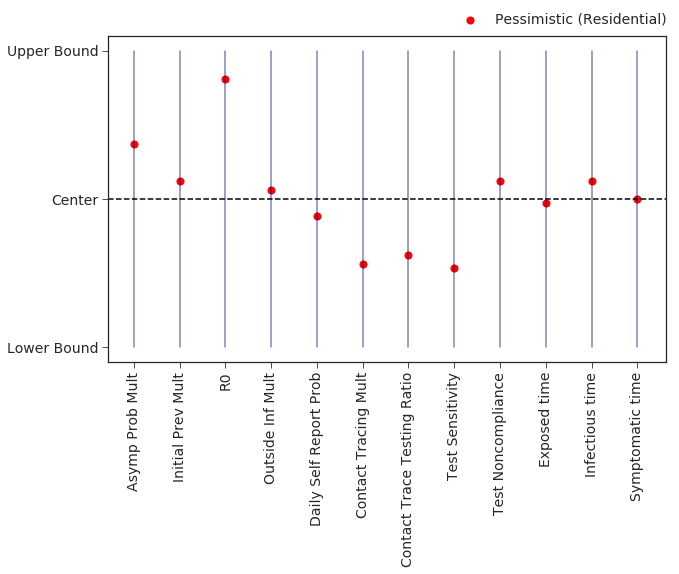

In [13]:
plt.figure(figsize=(10,6))
label = True

for index, param in enumerate(UNCERTAINTY_PARAMS_LIST[:12]):
    plt.plot([index, index], [0,1], color='navy', alpha=0.5)
    if label == True:
        plt.scatter(index, normalize_param(param, res_pessimistic[param]), color='red', label='Pessimistic (Residential)', s=50)
        label = False
    else:
        plt.scatter(index, normalize_param(param, res_pessimistic[param]), color='red', s=50)

plt.axhline(0.5, color='black', ls='--')

plt.xticks(list(range(len(UNCERTAINTY_PARAMS_LIST[:12]))), ['Asymp Prob Mult', 'Initial Prev Mult', 'R0', 'Outside Inf Mult',
                                          'Daily Self Report Prob', 'Contact Tracing Mult', 'Contact Trace Testing Ratio',
                                          'Test Sensitivity', 'Test Noncompliance', 'Exposed time', 'Infectious time', 'Symptomatic time'])
plt.xticks(rotation = 90)
plt.yticks([0,0.5,1], ['Lower Bound', 'Center', 'Upper Bound'])

# plt.xlabel('Parameter')
# plt.ylabel('Value')

plt.legend(bbox_to_anchor=(0.6,1.11), loc="upper left")
plt.show()

In [10]:
res_pessimistic, PARAM_BOUNDS

({'ct_testing_ratio': 0.8408882933907234,
  'outside_inf_mult': 1.0241384070908397,
  'E_time': 1.9781058849148887,
  'ct_mult': 1.3162323939656833,
  'ID_time': 3.1001602001642996,
  'R0': 3.525611538430936,
  'daily_self_report_prob': 0.34639409513141284,
  'test_noncompliance': 0.10516921933568774,
  'asymp_prob_mult': 1.1522097816900698,
  'Sy_time': 11.99746235017504,
  'test_sensitivity': 0.5210403803934798,
  'inital_prev_mult': 1.0513769799456971,
  'virtual_noncompliance': 0.5,
  'intermittent_non-compliance': 0.5,
  'virtual_r0_mult': 1.2349999999999999,
  'virtual_pop_size': 0.5},
 {'asymp_prob_mult': (0.5106382978723404, 1.4893617021276595),
  'inital_prev_mult': (0.5, 1.5),
  'R0': (1, 4),
  'outside_inf_mult': (0.5, 1.5),
  'daily_self_report_prob': (0.22, 0.5),
  'ct_mult': (1, 2),
  'ct_testing_ratio': (0.5, 1.5),
  'test_sensitivity': (0.4, 0.8),
  'test_noncompliance': (0.05, 0.15),
  'E_time': (1, 3),
  'ID_time': (2, 4),
  'Sy_time': (11, 13),
  'virtual_noncomplian

# Res - Vir Infections

In [14]:
scenario_data = load_sim_output(lhs_output_sim_files)
vir_results = virtual_vs_residential_regression(scenario_data)
vir_pessimistic = calculate_pessimistic_scenario(vir_results)
vir_pessimistic['const'] = 0

In [15]:
vir_pessimistic

{'ct_mult': 1.5590725867456006,
 'virtual_pop_size': 0.4250160047352576,
 'Sy_time': 11.935000269774681,
 'ct_testing_ratio': 1.0057420388371117,
 'virtual_noncompliance': 0.44605096865303384,
 'E_time': 1.993897515453085,
 'test_sensitivity': 0.6018377311456834,
 'virtual_r0_mult': 1.1386404664682888,
 'R0': 1.1059915332875805,
 'outside_inf_mult': 1.0003798027370396,
 'daily_self_report_prob': 0.3728841846082932,
 'inital_prev_mult': 0.9925614764285442,
 'test_noncompliance': 0.10172033202180288,
 'asymp_prob_mult': 0.7416890477835014,
 'ID_time': 2.866272190540004,
 'intermittent_non-compliance': 0.4655513678494027,
 'const': 0}

In [16]:
vir_results_summary = vir_results.summary()
vir_results_as_html = vir_results_summary.tables[1].as_html()
vir_lr_summary_df = pd.read_html(vir_results_as_html, header=0, index_col=0)[0]
vir_lr_summary_df
# lr_summary_df['coef'], coef_normalized

,coef,std err,t,P>|t|,[0.025,0.975]
const,19870.0000,827.543,24.016,0.000,18300.000,21500.000
asymp_prob_mult,-4341.5386,109.323,-39.713,0.000,-4555.938,-4127.139
inital_prev_mult,-119.7588,106.855,-1.121,0.263,-329.318,89.800
R0,-2493.6971,35.583,-70.082,0.000,-2563.480,-2423.914
outside_inf_mult,6.1148,106.662,0.057,0.954,-203.066,215.296
daily_self_report_prob,2645.8284,380.648,6.951,0.000,1899.316,3392.341
ct_mult,951.0575,106.562,8.925,0.000,742.072,1160.043
ct_testing_ratio,92.4457,106.752,0.866,0.387,-116.912,301.803
test_sensitivity,184.9195,266.984,0.693,0.489,-338.679,708.518
test_noncompliance,2769.7022,1066.233,2.598,0.009,678.647,4860.757


In [17]:
results_summary = vir_results.summary()
results_as_html = results_summary.tables[1].as_html()
lr_summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

coef_normalized = list()
for param, value in dict(lr_summary_df['coef']).items():
    if param == 'const':
        coef_normalized.append(value)
        continue
    param_range = PARAM_BOUNDS[param][1] - PARAM_BOUNDS[param][0]
    coef_normalized.append(value * param_range)
    
# std_err_normalized = list()
# for param, value in dict(lr_summary_df['std err']).items():
#     if param == 'const':
#         std_err_normalized.append(value)
#         continue
#     param_range = PARAM_BOUNDS[param][1] - PARAM_BOUNDS[param][0]
#     std_err_normalized.append(value * param_range)


lr_summary_df['coef*range'] = coef_normalized
# lr_summary_df['std err*range'] = std_err_normalized
# lr_summary_df['pess value'] = res_pessimistic

In [18]:
# lr_summary_df.columns
lr_summary_df[['coef', 'std err', 'P>|t|', 'coef*range']].round(3)

,coef,std err,P>|t|,coef*range
const,19870.000,827.543,0.000,19870.000
asymp_prob_mult,-4341.539,109.323,0.000,-4249.165
inital_prev_mult,-119.759,106.855,0.263,-119.759
R0,-2493.697,35.583,0.000,-7481.091
outside_inf_mult,6.115,106.662,0.954,6.115
daily_self_report_prob,2645.828,380.648,0.000,740.832
ct_mult,951.058,106.562,0.000,951.058
ct_testing_ratio,92.446,106.752,0.387,92.446
test_sensitivity,184.920,266.984,0.489,73.968
test_noncompliance,2769.702,1066.233,0.009,276.970


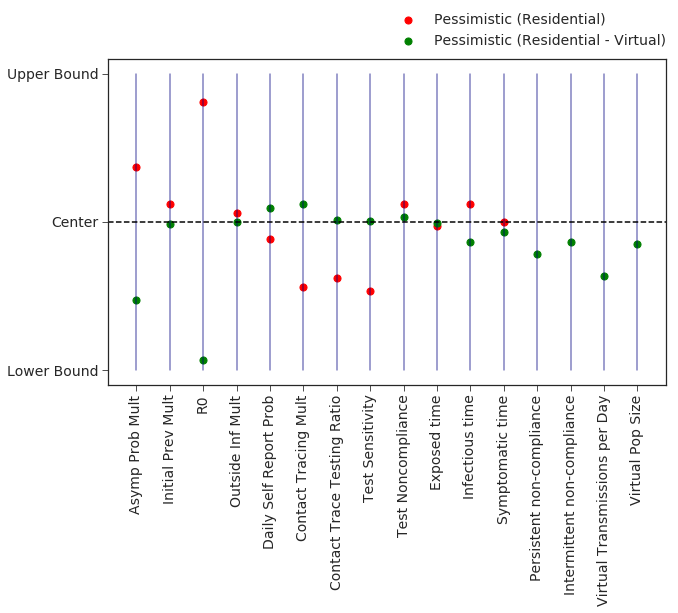

In [19]:
plt.figure(figsize=(10,6))
label = True

for index, param in enumerate(UNCERTAINTY_PARAMS_LIST[:12]):
    if label == True:
        plt.scatter(index, normalize_param(param, res_pessimistic[param]), color='red', label='Pessimistic (Residential)', s=50)
        label = False
    else:
        plt.scatter(index, normalize_param(param, res_pessimistic[param]), color='red', s=50)

label=True
for index, param in enumerate(UNCERTAINTY_PARAMS_LIST):
    plt.plot([index, index], [0,1], color='navy', alpha=0.5)
    if label == True:
        plt.scatter(index, normalize_param(param, vir_pessimistic[param]), color='green', label='Pessimistic (Residential - Virtual)', s=50)
        label = False
    else:
        plt.scatter(index, normalize_param(param, vir_pessimistic[param]), color='green', s=50)
        

plt.axhline(0.5, color='black', ls='--')

plt.xticks(list(range(len(UNCERTAINTY_PARAMS_LIST))), ['Asymp Prob Mult', 'Initial Prev Mult', 'R0', 'Outside Inf Mult',
                                          'Daily Self Report Prob', 'Contact Tracing Mult', 'Contact Trace Testing Ratio',
                                          'Test Sensitivity', 'Test Noncompliance', 'Exposed time', 'Infectious time', 'Symptomatic time',
                                          'Persistent non-compliance', 'Intermittent non-compliance',
                                          'Virtual Transmissions per Day', 'Virtual Pop Size'])
plt.xticks(rotation = 90)
plt.yticks([0,0.5,1], ['Lower Bound', 'Center', 'Upper Bound'])

# plt.xlabel('Parameter')
# plt.ylabel('Value')

plt.legend(bbox_to_anchor=(0.49,1.18), loc="upper left")
plt.show()